In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from k_means import run_kmeans

### Patrones horarios

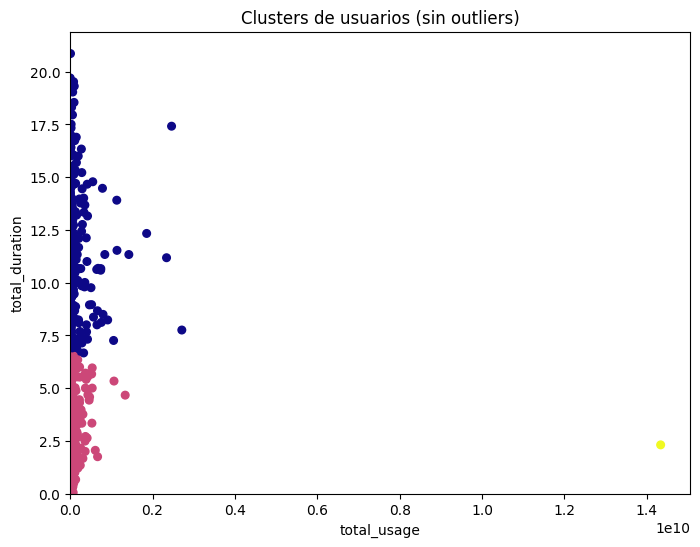

Resumen del día (00–08):
                 total_usage  total_duration  user_count  usage_percent
perfil_consumo                                                         
Alto            1.433565e+10        2.309444           1          16.91
Bajo            2.502157e+10     1087.141111         459          29.51
Normal          4.544086e+10     4595.859167         422          53.59


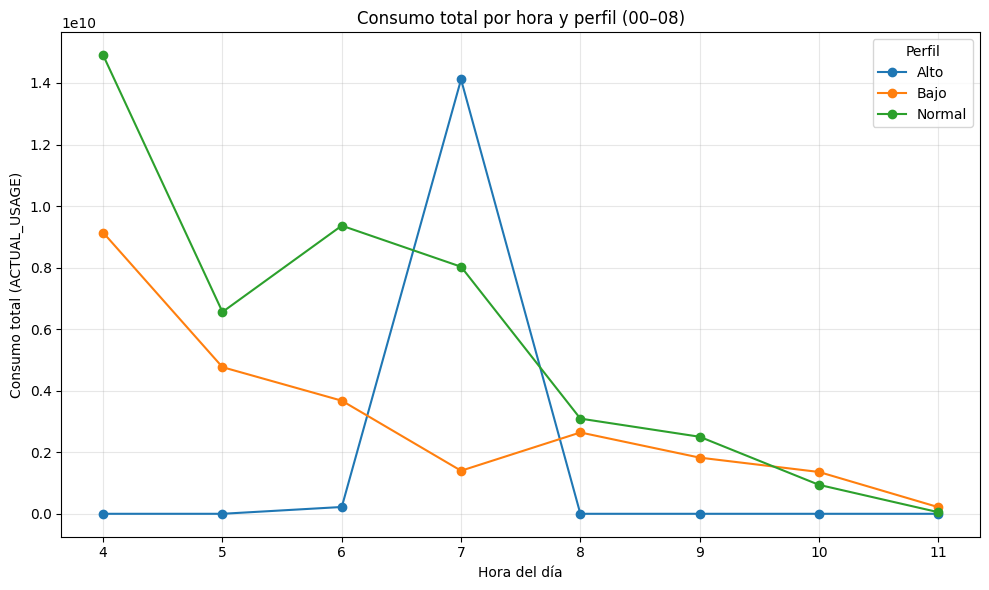

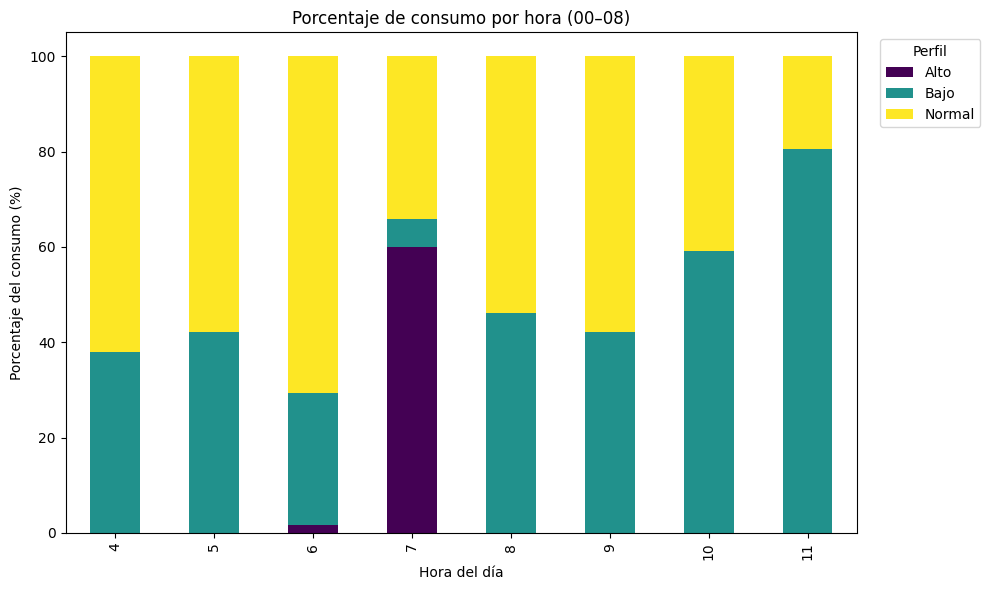

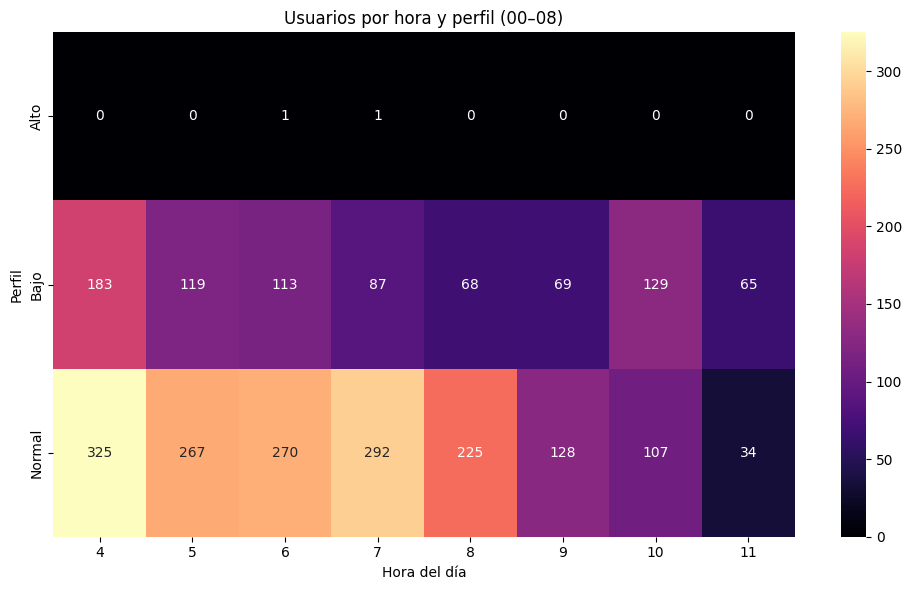

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Cargar dataset
df = pd.read_csv("../data/synthetic_data/datos_a_completar.csv")

# 2) Convertir fechas a datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'])
df['END_DATE'] = pd.to_datetime(df['END_DATE'])

# 3) Crear columna de duración en horas
df['DURATION_HOURS'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 3600

# 4) Cargar outliers detectados por DBSCAN
# outliers = pd.read_csv("../outliers-analysis/outliers.csv")

# # 5) Quitar outliers del dataset
# df_no_outliers = df[~df.index.isin(outliers.index)].copy()
# df_1 = df_no_outliers
df_1 = df

# 6) AGRUPAR POR USUARIO (OBJ_ID) antes de clustering  # <-- agregado
usuarios = df_1.groupby('OBJ_ID').agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    num_sessions=('ACTUAL_USAGE','count')
).reset_index()

# 7) Ejecutar tu método run_kmeans con las variables agregadas por usuario  # <-- cambiado
result = run_kmeans(usuarios, features=['total_usage','total_duration'])

# 8) Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_stats = result.groupby('cluster_kmeans')['total_usage'].mean().sort_values()  # <-- cambiado (usa total_usage)
orden = cluster_stats.index.tolist()
nombres = {orden[0]:'Bajo', orden[1]:'Normal', orden[2]:'Alto'}
result['perfil_consumo'] = result['cluster_kmeans'].map(nombres)

# 9) VOLVER A UNIR perfiles al dataset original para análisis horario  # <-- agregado
df_1 = df_1.merge(result[['OBJ_ID','perfil_consumo']], on='OBJ_ID', how='left')

# 10) Extraer hora del START_DATE
df_1['hour'] = df_1['START_DATE'].dt.hour

# 11) Agregaciones por hora y perfil (usuarios únicos en vez de filas)  # <-- cambiado
agg = df_1.groupby(['perfil_consumo','hour']).agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    user_count=('OBJ_ID','nunique')   # <-- cambiado: cuenta usuarios únicos
).reset_index()

# 12) Pivot para tablas por hora
usage_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='total_usage').fillna(0)
duration_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='total_duration').fillna(0)
count_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='user_count').fillna(0)
usage_hourly_pct = usage_hourly.div(usage_hourly.sum(axis=1).replace(0,np.nan), axis=0) * 100

# 13) Resumen total del día (usuarios únicos)  # <-- cambiado
day_summary = df_1.groupby('perfil_consumo').agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    user_count=('OBJ_ID','nunique')   # <-- cambiado
)
total_day_usage = day_summary['total_usage'].sum()
day_summary['usage_percent'] = (day_summary['total_usage']/total_day_usage*100).round(2)

print("Resumen del día (00–08):")
print(day_summary)

# 14) Visualizaciones
usage_hourly.plot(kind='line', marker='o', figsize=(10,6))
plt.title("Consumo total por hora y perfil (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Consumo total (ACTUAL_USAGE)")
plt.legend(title="Perfil")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("results/consumo_por_hora_lineas.png", dpi=300)
plt.show()
plt.close()

usage_hourly_pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title("Porcentaje de consumo por hora (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Porcentaje del consumo (%)")
plt.legend(title="Perfil", bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.savefig("results/consumo_por_hora_porcentaje.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10,6))
sns.heatmap(count_hourly.T, annot=True, fmt=".0f", cmap="magma")
plt.title("Usuarios por hora y perfil (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Perfil")
plt.tight_layout()
plt.savefig("results/usuarios_por_hora_heatmap.png", dpi=300)
plt.show()
plt.close()

# 15) Guardar reporte interpretado
with open("results/patrones_horarios.txt","w",encoding="utf-8") as f:
    f.write("Resumen del día (00–08):\n")
    for perfil,row in day_summary.iterrows():
        f.write(f"- {perfil}: usuarios={row['user_count']}, consumo_total={row['total_usage']:.2f}, "
                f"duracion_total_h={row['total_duration']:.2f}, participacion_consumo={row['usage_percent']:.2f}%\n")
    f.write("\nHallazgos por hora:\n")
    for h in sorted(usage_hourly.index):
        total_h = usage_hourly.loc[h].sum()
        f.write(f"Hora {h:02d}: consumo_total={total_h:.2f}\n")
        top_perfil = usage_hourly.loc[h].idxmax()
        top_val = usage_hourly.loc[h].max()
        f.write(f"  - Perfil dominante: {top_perfil} ({top_val:.2f})\n")
        for perfil in usage_hourly.columns:
            pct = usage_hourly_pct.loc[h, perfil]
            if not np.isnan(pct):
                f.write(f"  - {perfil}: {pct:.2f}% del consumo\n")
        counts = count_hourly.loc[h]
        f.write("  - Usuarios por perfil: " + ", ".join([f"{p}: {int(c)}" for p,c in counts.items()]) + "\n\n")


### Consumo vs Duracion

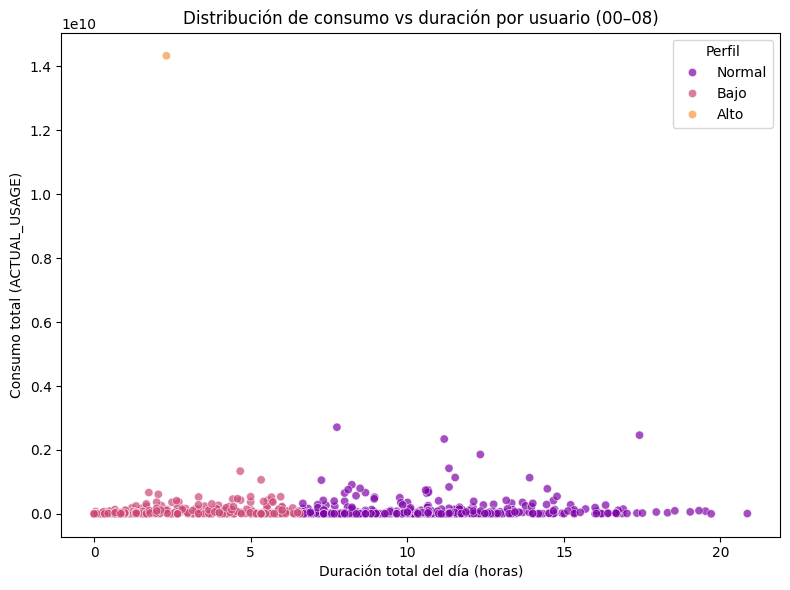

C:\Users\Joel\AppData\Local\Temp\ipykernel_18956\2799303329.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x='perfil_consumo', y='total_duration', palette='plasma')  # <-- cambiado


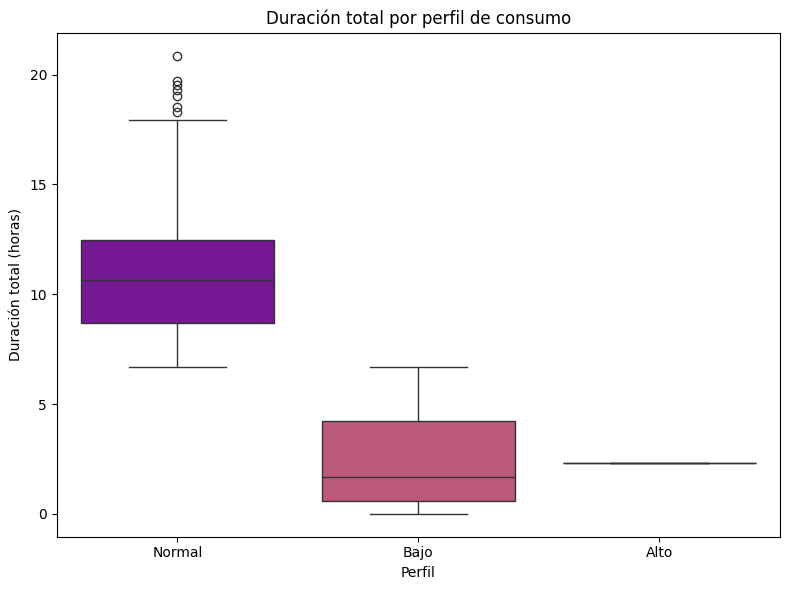

C:\Users\Joel\AppData\Local\Temp\ipykernel_18956\2799303329.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x='perfil_consumo', y='total_usage', palette='plasma')  # <-- cambiado


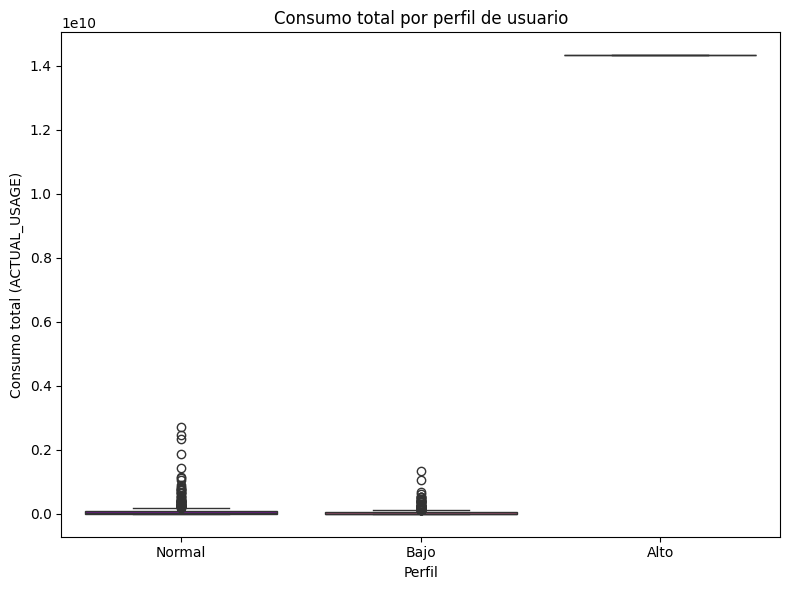

In [3]:
# Scatter plot consumo vs duración, coloreado por perfil
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=result,
    x='total_duration',    # <-- cambiado (usa total_duration)
    y='total_usage',       # <-- cambiado (usa total_usage)
    hue='perfil_consumo',
    palette='plasma',
    alpha=0.7
)
plt.title("Distribución de consumo vs duración por usuario (00–08)")   # <-- cambiado
plt.xlabel("Duración total del día (horas)")   # <-- cambiado
plt.ylabel("Consumo total (ACTUAL_USAGE)")     # <-- cambiado
plt.legend(title="Perfil")
plt.tight_layout()
plt.savefig("results/distribucion_consumo_duracion.png", dpi=300)
plt.show()
plt.close()

# Boxplot para comparar duración por perfil
plt.figure(figsize=(8,6))
sns.boxplot(data=result, x='perfil_consumo', y='total_duration', palette='plasma')  # <-- cambiado
plt.title("Duración total por perfil de consumo")   # <-- cambiado
plt.xlabel("Perfil")
plt.ylabel("Duración total (horas)")   # <-- cambiado
plt.tight_layout()
plt.savefig("results/boxplot_duracion_perfil.png", dpi=300)
plt.show()
plt.close()

# Boxplot para comparar consumo por perfil
plt.figure(figsize=(8,6))
sns.boxplot(data=result, x='perfil_consumo', y='total_usage', palette='plasma')  # <-- cambiado
plt.title("Consumo total por perfil de usuario")   # <-- cambiado
plt.xlabel("Perfil")
plt.ylabel("Consumo total (ACTUAL_USAGE)")   # <-- cambiado
plt.tight_layout()
plt.savefig("results/boxplot_consumo_perfil.png", dpi=300)
plt.show()
plt.close()


### Patron de outliers

In [4]:
# 1) Cargar outliers
outliers = pd.read_csv("../outliers-analysis/results/datos/DATOS_outliers.csv")

# 2) Asegurar que las fechas estén en datetime y recalcular duración si es posible
if 'START_DATE' in outliers.columns and 'END_DATE' in outliers.columns:
    outliers['START_DATE'] = pd.to_datetime(outliers['START_DATE'], errors='coerce')
    outliers['END_DATE'] = pd.to_datetime(outliers['END_DATE'], errors='coerce')

    if 'DURATION_HOURS' not in outliers.columns:
        outliers['DURATION_HOURS'] = (outliers['END_DATE'] - outliers['START_DATE']).dt.total_seconds() / 3600

# 3) Si aún no existe DURATION_HOURS, crearla como 0 para evitar KeyError  # <-- agregado
if 'DURATION_HOURS' not in outliers.columns:
    outliers['DURATION_HOURS'] = 0.0

# 4) Agrupar outliers por usuario (usa la columna correcta de ID)  # <-- cambiado
# Verifica si tu CSV usa 'ID' en vez de 'OBJ_ID'
id_col = 'OBJ_ID' if 'OBJ_ID' in outliers.columns else 'ID'

outliers_usuarios = outliers.groupby(id_col).agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    num_sessions=('ACTUAL_USAGE','count')
).reset_index()


### Trafico por cluster

Resumen de participación en el tráfico total:
                 total_usage  total_duration  user_count  usage_percent  \
perfil_consumo                                                            
Alto            1.433565e+10        2.309444           1          16.91   
Bajo            2.502157e+10     1087.141111         459          29.51   
Normal          4.544086e+10     4595.859167         422          53.59   

                usage_per_user  
perfil_consumo                  
Alto              1.433565e+10  
Bajo              5.451323e+07  
Normal            1.076798e+08  


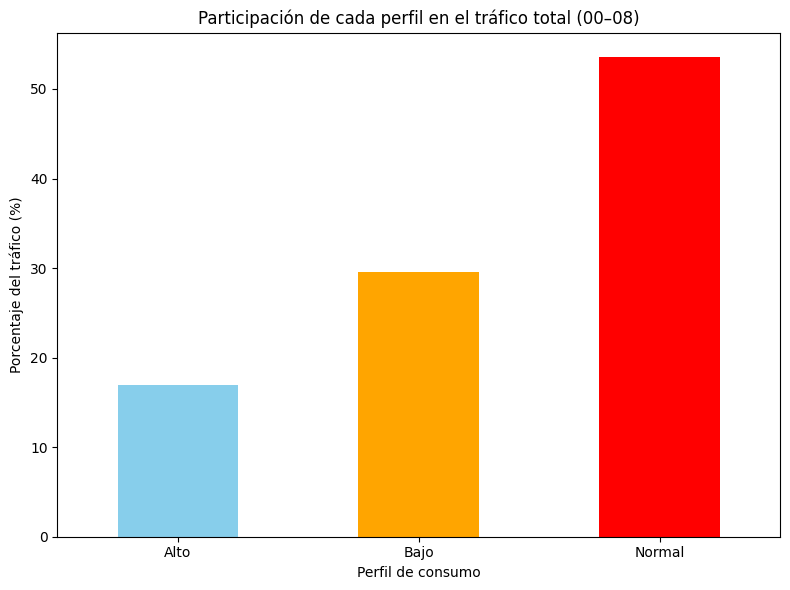

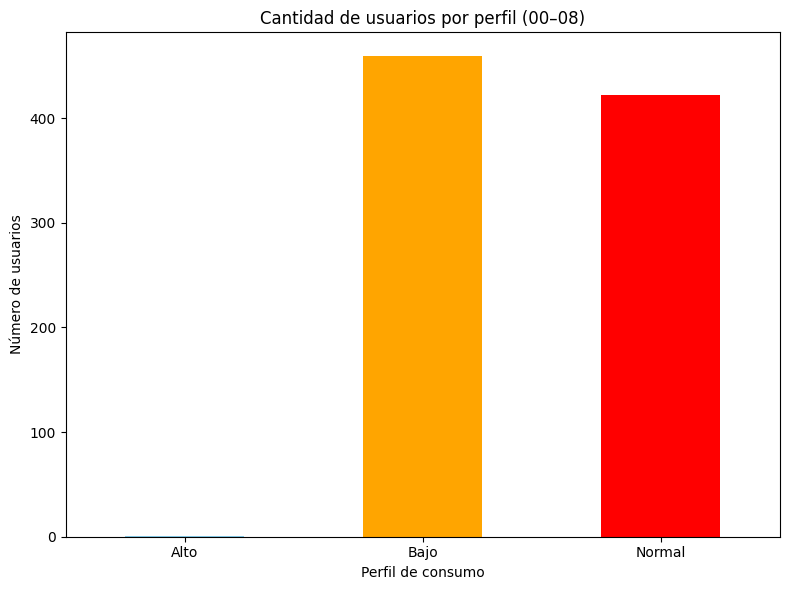

In [5]:
# 1) Resumen por perfil (usa métricas agregadas por usuario)  # <-- cambiado
cluster_summary = result.groupby('perfil_consumo').agg(
    total_usage=('total_usage','sum'),        # <-- cambiado
    total_duration=('total_duration','sum'),  # <-- cambiado
    user_count=('OBJ_ID','nunique')               # <-- cambiado: cuenta usuarios únicos
)

# 2) Porcentaje de tráfico total por cluster
total_usage = cluster_summary['total_usage'].sum()
cluster_summary['usage_percent'] = (cluster_summary['total_usage'] / total_usage * 100).round(2)

# 3) Consumo promedio por usuario en cada cluster
cluster_summary['usage_per_user'] = (cluster_summary['total_usage'] / cluster_summary['user_count']).round(2)

print("Resumen de participación en el tráfico total:")
print(cluster_summary)

# 4) Visualización: participación en el tráfico total
plt.figure(figsize=(8,6))
cluster_summary['usage_percent'].plot(kind='bar', color=['skyblue','orange','red'])
plt.title("Participación de cada perfil en el tráfico total (00–08)")
plt.xlabel("Perfil de consumo")
plt.ylabel("Porcentaje del tráfico (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/participacion_clusters.png", dpi=300)
plt.show()
plt.close()

# 5) Visualización: cantidad de usuarios por perfil
plt.figure(figsize=(8,6))
cluster_summary['user_count'].plot(kind='bar', color=['skyblue','orange','red'])
plt.title("Cantidad de usuarios por perfil (00–08)")
plt.xlabel("Perfil de consumo")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/usuarios_por_perfil.png", dpi=300)
plt.show()
plt.close()


### Clustering con reduccion de dimensionalidad

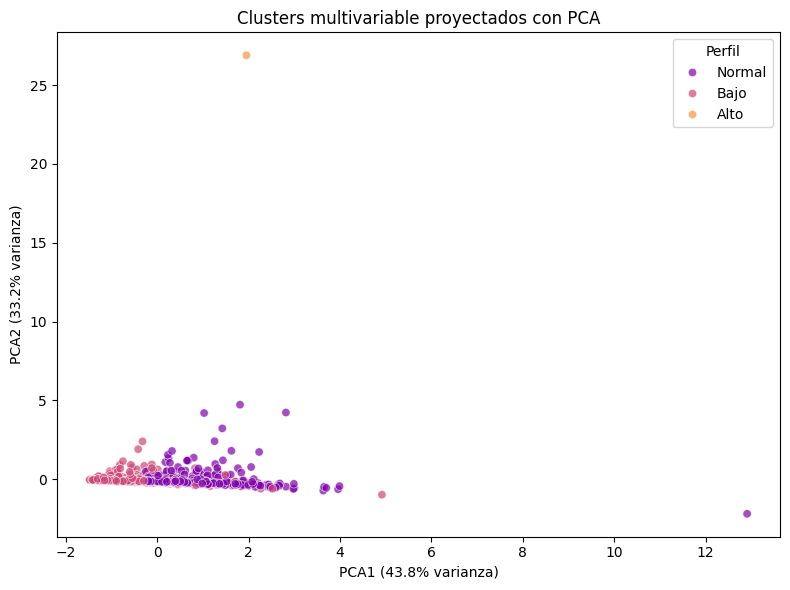

Contribución de cada variable a los componentes principales:
      total_usage  total_duration  num_sessions
PCA1     0.111495        0.704696      0.700694
PCA2     0.992445       -0.042627     -0.115049


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Seleccionar variables adicionales (usa métricas agregadas por usuario)  # <-- cambiado
features = ['total_usage','total_duration','num_sessions']   # <-- cambiado
# Si tienes más columnas relevantes, añádelas aquí, por ejemplo:
# features = ['total_usage','total_duration','num_sessions','VARIABILIDAD_CONSUMO']

X = result[features]   # <-- cambiado

# 2) Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) PCA a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4) Guardar resultados en el DataFrame
result['PCA1'] = X_pca[:,0]
result['PCA2'] = X_pca[:,1]

# 5) Visualización PCA coloreada por perfil
plt.figure(figsize=(8,6))
sns.scatterplot(data=result, x='PCA1', y='PCA2', hue='perfil_consumo', palette='plasma', alpha=0.7)
plt.title("Clusters multivariable proyectados con PCA")
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
plt.legend(title="Perfil")
plt.tight_layout()
plt.savefig("results/pca_clusters.png", dpi=300)
plt.show()
plt.close()

# 6) Importancia de cada variable en los componentes principales
pca_components = pd.DataFrame(pca.components_, columns=features, index=['PCA1','PCA2'])
print("Contribución de cada variable a los componentes principales:")
print(pca_components)


### Preferencia de bajos consumidores de datos por otros servicios

A continuació se analizan las preferencias de los bajos consumidores de datos móviles por sservicios de voz y SMS

#### Preferencia por SMS

Se plantea la hipótesis de que la gran parte de bajos consumidores de datos móviles prefieren el uso de mensajes, es decir, que 60% o más de los consumidores bajos de datos se encuentran entre los consumidores normales o altos de SMS con un 95% se seguridad.

In [7]:
# 1) Cargar muestra.xlsx (datos con TODOS los servicios)
df_completo = pd.read_excel("../data/muestra.xlsx")

# 2) Convertir fechas
df_completo['START_DATE'] = pd.to_datetime(df_completo['START_DATE'])
df_completo['END_DATE'] = pd.to_datetime(df_completo['END_DATE'])
df_completo['DURATION_HOURS'] = (df_completo['END_DATE'] - df_completo['START_DATE']).dt.total_seconds() / 3600

# 3) Ver qué SERVICE_CATEGORY tenemos
print("SERVICE_CATEGORY valores únicos:")
print(df_completo['SERVICE_CATEGORY'].value_counts())
print()

# 4) Datos para DATOS (SERVICE_CATEGORY=5) 
print("PASO 1: Analizando DATOS (SERVICE_CATEGORY=5)")
df_datos = df_completo[df_completo['SERVICE_CATEGORY'] == 5].copy()
print(f"Registros de DATOS: {len(df_datos)}")

usuarios_datos = df_datos.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_datos.columns = ['OWNER_CUST_ID', 'uso_datos']
print(f"Usuarios únicos en DATOS: {len(usuarios_datos)}")
print()

# 5) Datos para SMS (SERVICE_CATEGORY=2)
print("PASO 2: Analizando SMS (SERVICE_CATEGORY=2)")
df_sms = df_completo[df_completo['SERVICE_CATEGORY'] == 2].copy()
print(f"Registros de SMS: {len(df_sms)}")

usuarios_sms = df_sms.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms']
print(f"Usuarios únicos en SMS: {len(usuarios_sms)}")
print()


SERVICE_CATEGORY valores únicos:
SERVICE_CATEGORY
5     7875
2     1551
15     418
1      156
Name: count, dtype: int64

PASO 1: Analizando DATOS (SERVICE_CATEGORY=5)
Registros de DATOS: 7875
Usuarios únicos en DATOS: 881

PASO 2: Analizando SMS (SERVICE_CATEGORY=2)
Registros de SMS: 1551
Usuarios únicos en SMS: 324



In [8]:
# 6) K-MEANS CLUSTERING PARA DATOS usando run_kmeans
print("PASO 3: Clustering en DATOS (K-means)")

# Preparar dataframe con uso de datos por usuario
usuarios_datos_cluster = usuarios_datos[['OWNER_CUST_ID', 'uso_datos']].copy()
usuarios_datos_cluster = usuarios_datos_cluster.rename(columns={'uso_datos': 'total_usage'})

# Aplicar run_kmeans
result_datos = run_kmeans(usuarios_datos_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_datos = result_datos.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_datos = cluster_medias_datos.index.tolist()
mapeo_datos = {orden_datos[0]: 'Bajo', orden_datos[1]: 'Normal', orden_datos[2]: 'Alto'}
result_datos['perfil_datos'] = result_datos['cluster_kmeans'].map(mapeo_datos)

# Volver a unir con OWNER_CUST_ID
result_datos_reset = result_datos.reset_index()
usuarios_datos = result_datos_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_datos']].copy()
usuarios_datos.columns = ['OWNER_CUST_ID', 'uso_datos', 'cluster_datos', 'perfil_datos']

print("\nPerfiles en DATOS:")
print(usuarios_datos.groupby('perfil_datos')['uso_datos'].describe())
print()

# 7) K-MEANS CLUSTERING PARA SMS usando run_kmeans
print("PASO 4: Clustering en SMS (K-means)")

# Preparar dataframe con uso de SMS por usuario
usuarios_sms_cluster = usuarios_sms[['OWNER_CUST_ID', 'uso_sms']].copy()
usuarios_sms_cluster = usuarios_sms_cluster.rename(columns={'uso_sms': 'total_usage'})

# Aplicar run_kmeans
result_sms = run_kmeans(usuarios_sms_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_sms = result_sms.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_sms = cluster_medias_sms.index.tolist()
mapeo_sms = {orden_sms[0]: 'Bajo', orden_sms[1]: 'Normal', orden_sms[2]: 'Alto'}
result_sms['perfil_sms'] = result_sms['cluster_kmeans'].map(mapeo_sms)

# Volver a unir con OWNER_CUST_ID
result_sms_reset = result_sms.reset_index()
usuarios_sms = result_sms_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_sms']].copy()
usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms', 'cluster_sms', 'perfil_sms']

print("\nPerfiles en SMS:")
print(usuarios_sms.groupby('perfil_sms')['uso_sms'].describe())
print()


PASO 3: Clustering en DATOS (K-means)

Perfiles en DATOS:
              count          mean           std           min           25%  \
perfil_datos                                                                  
Alto            1.0  1.433565e+10           NaN  1.433565e+10  1.433565e+10   
Bajo          850.0  4.789253e+07  8.644309e+07  6.000000e+01  1.767389e+06   
Normal         30.0  9.917927e+08  6.010238e+08  5.200047e+08  6.185881e+08   

                       50%           75%           max  
perfil_datos                                            
Alto          1.433565e+10  1.433565e+10  1.433565e+10  
Bajo          9.804939e+06  4.777352e+07  5.056341e+08  
Normal        7.498237e+08  1.114519e+09  2.710554e+09  

PASO 4: Clustering en SMS (K-means)

Perfiles en SMS:
            count        mean       std    min     25%    50%     75%    max
perfil_sms                                                                  
Alto          1.0  123.000000       NaN  123.0  123.

In [9]:
# 8) TEST DE HIPÓTESIS: ¿Bajos consumidores de datos prefieren SMS?
# Hipótesis: H0: p <= 0.60 (60% o menos de bajos consumidores de datos son altos/normales en SMS)
# Hipótesis alternativa H1: p > 0.60

print("="*70)
print("TEST DE HIPÓTESIS: PREFERENCIA DE SMS POR BAJOS CONSUMIDORES DE DATOS")
print("="*70)
print()

# Cruzar información: usuarios bajos en datos vs su clasificación en SMS
cruce = usuarios_datos.merge(usuarios_sms, on='OWNER_CUST_ID', how='inner')

# Identificar bajos consumidores de datos
bajos_datos = cruce[cruce['perfil_datos'] == 'Bajo'].copy()

print(f"Total de bajos consumidores de DATOS: {len(bajos_datos)}")
print(f"Distribución en bajos consumidores de DATOS:")
print(bajos_datos['perfil_sms'].value_counts())
print()

# De los bajos en datos, contar cuántos son ALTOS o NORMALES en SMS
bajos_datos['es_alto_o_normal_sms'] = bajos_datos['perfil_sms'].isin(['Alto', 'Normal'])
count_altos_normales = bajos_datos['es_alto_o_normal_sms'].sum()
proporcion_observada = count_altos_normales / len(bajos_datos) if len(bajos_datos) > 0 else 0

print(f"Bajos en DATOS que son ALTOS o NORMALES en SMS: {count_altos_normales} de {len(bajos_datos)}")
print(f"Proporción observada: {proporcion_observada:.4f} ({proporcion_observada*100:.2f}%)")
print()

# TEST DE PROPORCIÓN CON 95% DE CONFIANZA
# Usando test binomial
from scipy.stats import binomtest
p0 = 0.60  # proporción bajo la hipótesis nula
n = len(bajos_datos)
x = count_altos_normales

# Test unilateral (cola derecha): ¿es la proporción significativamente mayor a 60%?
result_binom = binomtest(x, n, p0, alternative='greater')
pvalue = result_binom.pvalue

print("TEST BINOMIAL (Hipótesis unilateral cola derecha):")
print(f"H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente SMS)")
print(f"H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente SMS)")
print(f"Nivel de significancia: α = 0.05 (confianza 95%)")
print(f"p-value: {pvalue:.6f}")
print()

if pvalue < 0.05:
    print("✅ RESULTADO: RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, la mayoría de bajos consumidores de datos")
    print("   SÍ prefieren SMS (más del 60% son altos/normales en SMS)")
else:
    print("❌ RESULTADO: NO RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de")
    print("   bajos consumidores de datos prefieren SMS")

print()
print("="*70)

# INTERVALO DE CONFIANZA AL 95%
# Intervalo de confianza de Wilson
def wilson_ci(x, n, confidence=0.95):
    alpha = 1 - confidence
    z = stats.norm.ppf(1 - alpha/2)
    p_hat = x / n
    denominator = 1 + z**2/n
    centre_adjusted = (p_hat + z**2/(2*n)) / denominator
    adjusted_deviation = z * np.sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2)) / denominator
    return (centre_adjusted - adjusted_deviation, centre_adjusted + adjusted_deviation)

ic_lower, ic_upper = wilson_ci(x, n, 0.95)

print("INTERVALO DE CONFIANZA AL 95% (Método de Wilson):")
print(f"IC: [{ic_lower:.4f}, {ic_upper:.4f}]")
print(f"IC: [{ic_lower*100:.2f}%, {ic_upper*100:.2f}%]")
print()

if ic_lower > 0.60:
    print("✅ El intervalo está completamente por encima de 60%")
    print("   Confirmamos: Más del 60% de bajos consumidores de datos prefieren SMS")
elif ic_upper < 0.60:
    print("❌ El intervalo está completamente por debajo de 60%")
    print("   No se cumple la hipótesis")
else:
    print("⚠️  El intervalo contiene 60%")
    print("   El resultado es borderline/inconcluso")


TEST DE HIPÓTESIS: PREFERENCIA DE SMS POR BAJOS CONSUMIDORES DE DATOS

Total de bajos consumidores de DATOS: 152
Distribución en bajos consumidores de DATOS:
perfil_sms
Bajo      138
Normal     14
Name: count, dtype: int64

Bajos en DATOS que son ALTOS o NORMALES en SMS: 14 de 152
Proporción observada: 0.0921 (9.21%)

TEST BINOMIAL (Hipótesis unilateral cola derecha):
H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente SMS)
H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente SMS)
Nivel de significancia: α = 0.05 (confianza 95%)
p-value: 1.000000

❌ RESULTADO: NO RECHAZAMOS H0
   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de
   bajos consumidores de datos prefieren SMS

INTERVALO DE CONFIANZA AL 95% (Método de Wilson):
IC: [0.0557, 0.1487]
IC: [5.57%, 14.87%]

❌ El intervalo está completamente por debajo de 60%
   No se cumple la hipótesis



TABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en SMS
perfil_sms    Bajo  Normal  All
perfil_datos                   
Bajo           138      14  152
All            138      14  152



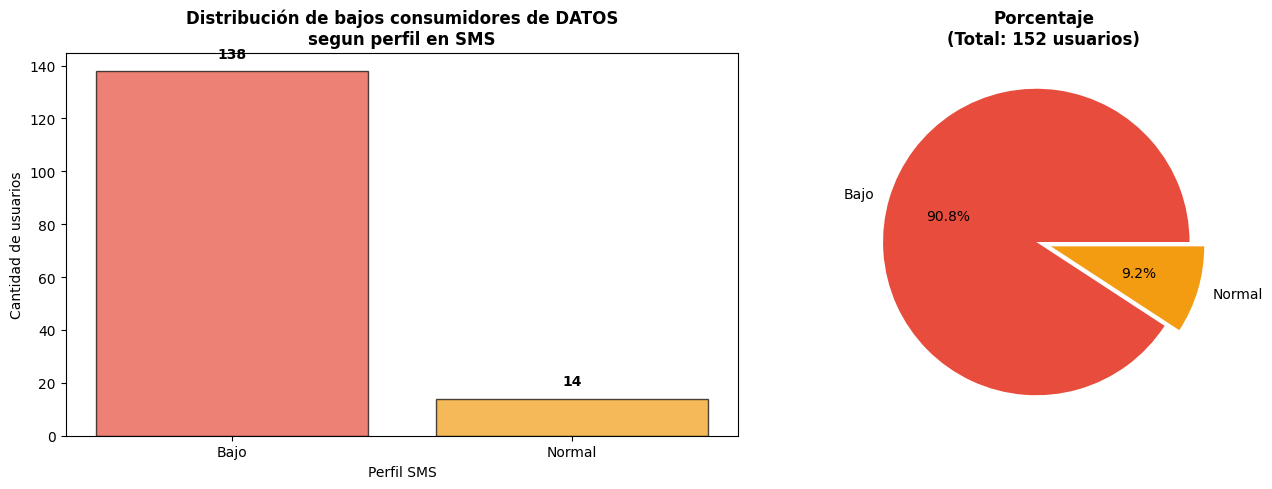

C:\Users\Joel\AppData\Local\Temp\ipykernel_18956\2557946786.py:75: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Joel\AppData\Local\Temp\ipykernel_18956\2557946786.py:76: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("results/test_hipotesis_proporcion.png", dpi=300, bbox_inches='tight')
C:\Users\Joel\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


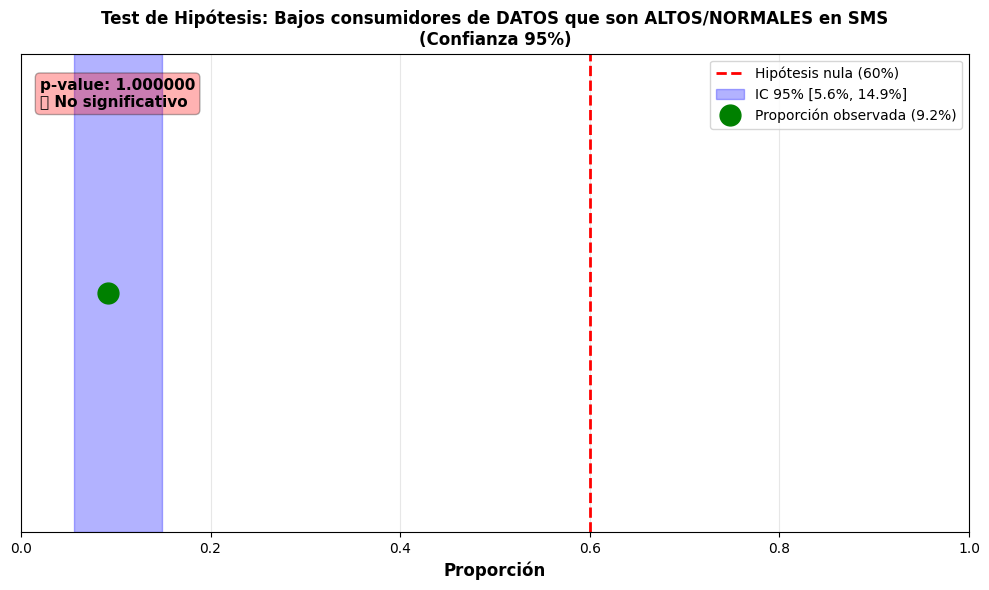

✅ Gráficos guardados en results/


In [10]:
# 8) VISUALIZACIONES DEL TEST

# Tabla resumen de perfiles cruzados
print("\nTABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en SMS")
contingencia = pd.crosstab(
    bajos_datos['perfil_datos'], 
    bajos_datos['perfil_sms'], 
    margins=True
)
print(contingencia)
print()

# Gráfico 1: Distribución de bajos consumidores de datos por perfil en SMS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras: conteo
perfiles_sms_count = bajos_datos['perfil_sms'].value_counts()
colors_sms = ['#e74c3c' if p == 'Bajo' else '#f39c12' if p == 'Normal' else '#27ae60' for p in perfiles_sms_count.index]
axes[0].bar(perfiles_sms_count.index, perfiles_sms_count.values, color=colors_sms, alpha=0.7, edgecolor='black')
axes[0].set_title("Distribución de bajos consumidores de DATOS\nsegun perfil en SMS", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Cantidad de usuarios")
axes[0].set_xlabel("Perfil SMS")
for i, v in enumerate(perfiles_sms_count.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Gráfico de pastel: porcentaje
perfiles_sms_pct = (bajos_datos['perfil_sms'].value_counts() / len(bajos_datos) * 100)
colors_pie = ['#e74c3c', '#f39c12', '#27ae60']
explode = (0.05 if perfiles_sms_pct.index[0] == 'Bajo' else 0,
           0.05 if 'Normal' in perfiles_sms_pct.index else 0,
           0.05 if 'Alto' in perfiles_sms_pct.index else 0)
axes[1].pie(perfiles_sms_pct.values, labels=perfiles_sms_pct.index, autopct='%1.1f%%',
            colors=colors_pie[:len(perfiles_sms_pct)], explode=explode[:len(perfiles_sms_pct)])
axes[1].set_title(f"Porcentaje\n(Total: {len(bajos_datos)} usuarios)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("results/hipotesis_bajos_datos_sms.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Gráfico 2: Visualización del test - barra de proporción con IC
fig, ax = plt.subplots(figsize=(10, 6))

# Línea de H0
ax.axvline(x=0.60, color='red', linestyle='--', linewidth=2, label='Hipótesis nula (60%)')

# IC como rango sombreado
ax.axvspan(ic_lower, ic_upper, alpha=0.3, color='blue', label=f'IC 95% [{ic_lower*100:.1f}%, {ic_upper*100:.1f}%]')

# Punto de proporción observada
ax.plot(proporcion_observada, 0, 'go', markersize=15, label=f'Proporción observada ({proporcion_observada*100:.1f}%)')

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Proporción', fontsize=12, fontweight='bold')
ax.set_title('Test de Hipótesis: Bajos consumidores de DATOS que son ALTOS/NORMALES en SMS\n(Confianza 95%)', 
             fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')

# Añadir texto con resultado
resultado_texto = f"p-value: {pvalue:.6f}\n"
if pvalue < 0.05:
    resultado_texto += "✅ Resultado significativo"
    color_resultado = 'green'
else:
    resultado_texto += "❌ No significativo"
    color_resultado = 'red'

ax.text(0.02, 0.95, resultado_texto, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_resultado, alpha=0.3),
        fontweight='bold')

plt.tight_layout()
plt.savefig("results/test_hipotesis_proporcion.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Gráficos guardados en results/")


#### Preferencia de bajos consumidores de datos móviles por las llamadas


Se plantea la hipótesis de que la gran parte de bajos consumidores de datos móviles prefieren las llamadas, es decir, que 60% o más de los consumidores bajos de datos se encuentran entre los consumidores normales o altos de voz con un 95% se seguridad.

In [11]:
# 1) Datos para VOZ (SERVICE_CATEGORY=1)
print("="*70)
print("ANÁLISIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS")
print("="*70)
print()

print("PASO 1: Analizando VOZ (SERVICE_CATEGORY=1)")
df_voz = df_completo[df_completo['SERVICE_CATEGORY'] == 1].copy()
print(f"Registros de VOZ: {len(df_voz)}")

usuarios_voz = df_voz.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz']
print(f"Usuarios únicos en VOZ: {len(usuarios_voz)}")
print()


ANÁLISIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS

PASO 1: Analizando VOZ (SERVICE_CATEGORY=1)
Registros de VOZ: 156
Usuarios únicos en VOZ: 89



In [12]:
# 2) K-MEANS CLUSTERING PARA VOZ usando run_kmeans
print("PASO 2: Clustering en VOZ (K-means)")

# Preparar dataframe con uso de voz por usuario
usuarios_voz_cluster = usuarios_voz[['OWNER_CUST_ID', 'uso_voz']].copy()
usuarios_voz_cluster = usuarios_voz_cluster.rename(columns={'uso_voz': 'total_usage'})

# Aplicar run_kmeans
result_voz = run_kmeans(usuarios_voz_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_voz = result_voz.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_voz = cluster_medias_voz.index.tolist()
mapeo_voz = {orden_voz[0]: 'Bajo', orden_voz[1]: 'Normal', orden_voz[2]: 'Alto'}
result_voz['perfil_voz'] = result_voz['cluster_kmeans'].map(mapeo_voz)

# Volver a unir con OWNER_CUST_ID
result_voz_reset = result_voz.reset_index()
usuarios_voz = result_voz_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_voz']].copy()
usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz', 'cluster_voz', 'perfil_voz']

print("\nPerfiles en VOZ:")
print(usuarios_voz.groupby('perfil_voz')['uso_voz'].describe())
print()


PASO 2: Clustering en VOZ (K-means)

Perfiles en VOZ:
            count         mean         std     min     25%     50%     75%  \
perfil_voz                                                                   
Alto          1.0  1327.000000         NaN  1327.0  1327.0  1327.0  1327.0   
Bajo         77.0    47.194805   42.362483     0.0    14.0    35.0    60.0   
Normal       11.0   316.000000  126.790378   182.0   231.5   277.0   337.0   

               max  
perfil_voz          
Alto        1327.0  
Bajo         157.0  
Normal       602.0  



In [13]:
# 3) TEST DE HIPÓTESIS: ¿Bajos consumidores de datos prefieren VOZ?
# Hipótesis: H0: p <= 0.60 (60% o menos de bajos consumidores de datos son altos/normales en VOZ)
# Hipótesis alternativa H1: p > 0.60

print("="*70)
print("TEST DE HIPÓTESIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS")
print("="*70)
print()

# Cruzar información: usuarios bajos en datos vs su clasificación en VOZ
cruce_voz = usuarios_datos.merge(usuarios_voz, on='OWNER_CUST_ID', how='inner')

# Identificar bajos consumidores de datos
bajos_datos_voz = cruce_voz[cruce_voz['perfil_datos'] == 'Bajo'].copy()

print(f"Total de bajos consumidores de DATOS: {len(bajos_datos_voz)}")
print(f"Distribución en bajos consumidores de DATOS:")
print(bajos_datos_voz['perfil_voz'].value_counts())
print()

# De los bajos en datos, contar cuántos son ALTOS o NORMALES en VOZ
bajos_datos_voz['es_alto_o_normal_voz'] = bajos_datos_voz['perfil_voz'].isin(['Alto', 'Normal'])
count_altos_normales_voz = bajos_datos_voz['es_alto_o_normal_voz'].sum()
proporcion_observada_voz = count_altos_normales_voz / len(bajos_datos_voz) if len(bajos_datos_voz) > 0 else 0

print(f"Bajos en DATOS que son ALTOS o NORMALES en VOZ: {count_altos_normales_voz} de {len(bajos_datos_voz)}")
print(f"Proporción observada: {proporcion_observada_voz:.4f} ({proporcion_observada_voz*100:.2f}%)")
print()

# TEST DE PROPORCIÓN CON 95% DE CONFIANZA
p0_voz = 0.60  # proporción bajo la hipótesis nula
n_voz = len(bajos_datos_voz)
x_voz = count_altos_normales_voz

# Test unilateral (cola derecha)
result_binom_voz = binomtest(x_voz, n_voz, p0_voz, alternative='greater')
pvalue_voz = result_binom_voz.pvalue

print("TEST BINOMIAL (Hipótesis unilateral cola derecha):")
print(f"H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente VOZ)")
print(f"H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente VOZ)")
print(f"Nivel de significancia: α = 0.05 (confianza 95%)")
print(f"p-value: {pvalue_voz:.6f}")
print()

if pvalue_voz < 0.05:
    print("✅ RESULTADO: RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, la mayoría de bajos consumidores de datos")
    print("   SÍ prefieren VOZ (más del 60% son altos/normales en VOZ)")
else:
    print("❌ RESULTADO: NO RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de")
    print("   bajos consumidores de datos prefieren VOZ")

print()
print("="*70)

# INTERVALO DE CONFIANZA AL 95%
ic_lower_voz, ic_upper_voz = wilson_ci(x_voz, n_voz, 0.95)

print("INTERVALO DE CONFIANZA AL 95% (Método de Wilson):")
print(f"IC: [{ic_lower_voz:.4f}, {ic_upper_voz:.4f}]")
print(f"IC: [{ic_lower_voz*100:.2f}%, {ic_upper_voz*100:.2f}%]")
print()

if ic_lower_voz > 0.60:
    print("✅ El intervalo está completamente por encima de 60%")
    print("   Confirmamos: Más del 60% de bajos consumidores de datos prefieren VOZ")
elif ic_upper_voz < 0.60:
    print("❌ El intervalo está completamente por debajo de 60%")
    print("   No se cumple la hipótesis")
else:
    print("⚠️  El intervalo contiene 60%")
    print("   El resultado es borderline/inconcluso")


TEST DE HIPÓTESIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS

Total de bajos consumidores de DATOS: 43
Distribución en bajos consumidores de DATOS:
perfil_voz
Bajo      34
Normal     8
Alto       1
Name: count, dtype: int64

Bajos en DATOS que son ALTOS o NORMALES en VOZ: 9 de 43
Proporción observada: 0.2093 (20.93%)

TEST BINOMIAL (Hipótesis unilateral cola derecha):
H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente VOZ)
H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente VOZ)
Nivel de significancia: α = 0.05 (confianza 95%)
p-value: 1.000000

❌ RESULTADO: NO RECHAZAMOS H0
   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de
   bajos consumidores de datos prefieren VOZ

INTERVALO DE CONFIANZA AL 95% (Método de Wilson):
IC: [0.1142, 0.3521]
IC: [11.42%, 35.21%]

❌ El intervalo está completamente por debajo de 60%
   No se cumple la hipótesis



TABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en VOZ
perfil_voz    Alto  Bajo  Normal  All
perfil_datos                         
Bajo             1    34       8   43
All              1    34       8   43



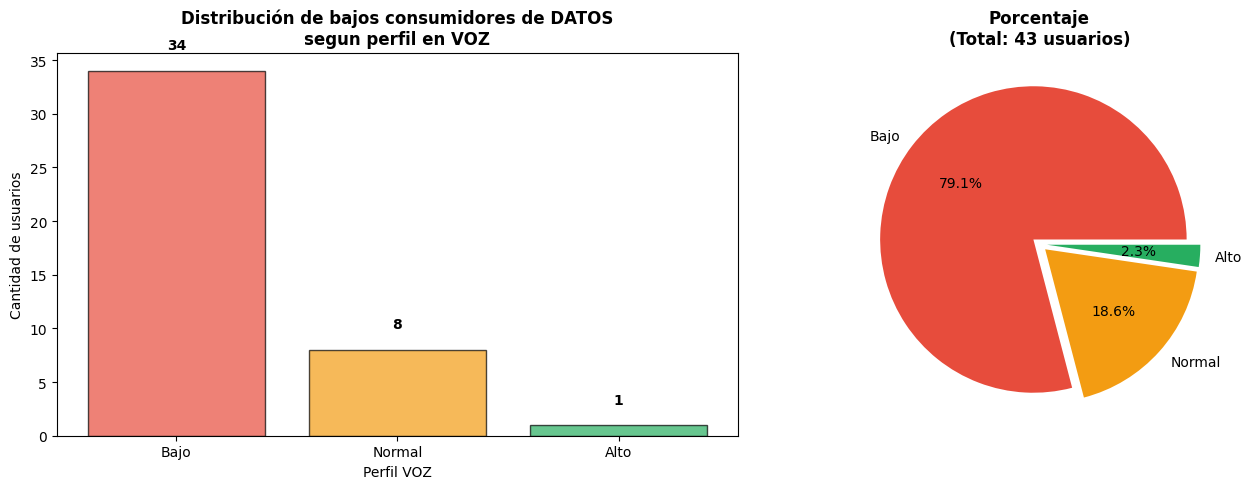

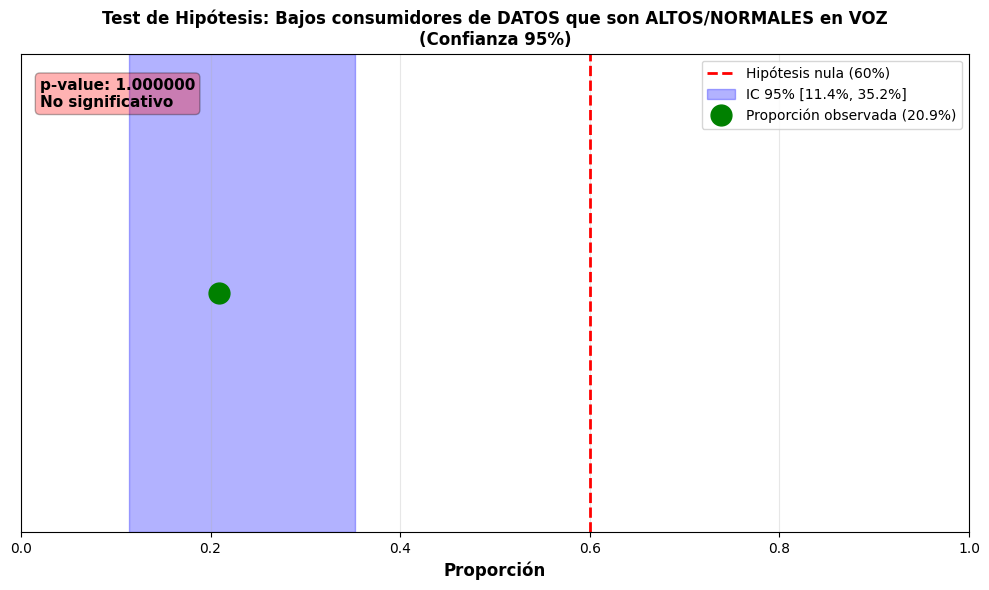

✅ Gráficos VOZ guardados en results/


In [14]:
# 4) VISUALIZACIONES DEL TEST VOZ

# Tabla resumen de perfiles cruzados
print("\nTABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en VOZ")
contingencia_voz = pd.crosstab(
    bajos_datos_voz['perfil_datos'], 
    bajos_datos_voz['perfil_voz'], 
    margins=True
)
print(contingencia_voz)
print()

# Gráfico 1: Distribución de bajos consumidores de datos por perfil en VOZ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras: conteo
perfiles_voz_count = bajos_datos_voz['perfil_voz'].value_counts()
colors_voz = ['#e74c3c' if p == 'Bajo' else '#f39c12' if p == 'Normal' else '#27ae60' for p in perfiles_voz_count.index]
axes[0].bar(perfiles_voz_count.index, perfiles_voz_count.values, color=colors_voz, alpha=0.7, edgecolor='black')
axes[0].set_title("Distribución de bajos consumidores de DATOS\nsegun perfil en VOZ", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Cantidad de usuarios")
axes[0].set_xlabel("Perfil VOZ")
for i, v in enumerate(perfiles_voz_count.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Gráfico de pastel: porcentaje
perfiles_voz_pct = (bajos_datos_voz['perfil_voz'].value_counts() / len(bajos_datos_voz) * 100)
colors_pie = ['#e74c3c', '#f39c12', '#27ae60']
explode = (0.05 if perfiles_voz_pct.index[0] == 'Bajo' else 0,
           0.05 if 'Normal' in perfiles_voz_pct.index else 0,
           0.05 if 'Alto' in perfiles_voz_pct.index else 0)
axes[1].pie(perfiles_voz_pct.values, labels=perfiles_voz_pct.index, autopct='%1.1f%%',
            colors=colors_pie[:len(perfiles_voz_pct)], explode=explode[:len(perfiles_voz_pct)])
axes[1].set_title(f"Porcentaje\n(Total: {len(bajos_datos_voz)} usuarios)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("results/hipotesis_bajos_datos_voz.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Gráfico 2: Visualización del test - barra de proporción con IC
fig, ax = plt.subplots(figsize=(10, 6))

# Línea de H0
ax.axvline(x=0.60, color='red', linestyle='--', linewidth=2, label='Hipótesis nula (60%)')

# IC como rango sombreado
ax.axvspan(ic_lower_voz, ic_upper_voz, alpha=0.3, color='blue', label=f'IC 95% [{ic_lower_voz*100:.1f}%, {ic_upper_voz*100:.1f}%]')

# Punto de proporción observada
ax.plot(proporcion_observada_voz, 0, 'go', markersize=15, label=f'Proporción observada ({proporcion_observada_voz*100:.1f}%)')

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Proporción', fontsize=12, fontweight='bold')
ax.set_title('Test de Hipótesis: Bajos consumidores de DATOS que son ALTOS/NORMALES en VOZ\n(Confianza 95%)', 
             fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')

# Añadir texto con resultado
resultado_texto_voz = f"p-value: {pvalue_voz:.6f}\n"
if pvalue_voz < 0.05:
    resultado_texto_voz += "Resultado significativo"
    color_resultado_voz = 'green'
else:
    resultado_texto_voz += "No significativo"
    color_resultado_voz = 'red'

ax.text(0.02, 0.95, resultado_texto_voz, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_resultado_voz, alpha=0.3),
        fontweight='bold')

plt.tight_layout()
plt.savefig("results/test_hipotesis_voz.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Gráficos VOZ guardados en results/")
